In [2]:
import os
# 이미지 다운
if not os.path.exists('train2017'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/zips/train2017.zip
    !unzip train2017.zip
    
# 캡션 다운
if not os.path.exists('annotations'):
    # 파일이 존재하지 않을 때 실행할 코드
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    !unzip annotations_trainval2017.zip

--2023-11-30 00:45:59--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.0.155, 52.217.140.105, 52.216.154.28, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.0.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip         0%[                    ]  65.67M  16.3MB/s    eta 27m 44s^C
Archive:  train2017.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train2017.zip or
        train2017.zip.zip, and cannot find train2017.zip.ZIP, period.
--2023-11-30 00:46:07--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.c

In [ ]:
# 데이터 분할
# dataPrepare.py에서 데이터 비율 및 vocab을 정의할 수 있다.
if not os.path.exists('dataset'):
    !python3 dataPrepare.py

[nltk_data] Downloading package punkt to /home/whitdisa04/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.LANCZOS)
dataPrepare.py:33: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LAN

In [ ]:
import os
import pickle
import torch
from torchvision import transforms
from dataLoader import get_loader
from model import *

In [ ]:
img_dir = ["./dataset/train/images", "./dataset/val/images", "./dataset/test/images"] 

image_paths = "./train2017" # original image
train_img_path = img_dir[0] # resized image for training
val_img_path = img_dir[1] # resized image for validation
test_img_path = img_dir[2] # resized image for test
size = [256, 256]

coco_caption_path = "./annotations/captions_train2017.json"
train_caption_path = "./dataset/train/captions.txt" # resized image for training
val_caption_path = "./dataset/val/captions.txt" # resized image for validation
test_caption_path = "./dataset/test/captions.txt" # resized image for test

batch_size = 128
num_workers = 6

vocab_path = "./dataset/vocab.pkl"  # Path to the preprocessed vocabulary file
# Load vocabulary file
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/vocab.pkl'

In [ ]:
model_path = "models/"  # Path where the trained model will be saved
# Create model directory
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Use the same preprocessing and normalization parameters as were applied in the pre-trained Inception model.
train_transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor()
])


# Declare data loaders
train_data_loader = get_loader(train_img_path, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False, pin_memory=True)
val_data_loader = get_loader(val_img_path, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False, pin_memory=True)
test_data_loader = get_loader(test_img_path, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True, pin_memory=True)

In [ ]:
# Increase Model Capacity
embed_size = 256
hidden_size = 512
num_layers = 1  # More layers can capture complex patterns

num_epochs = 10
learning_rate = 0.001

processing_step = 40
model_saving_step = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# Criterion with ignore_index to skip pad tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.batch_norm.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

/home/whitdisa04/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/whitdisa04/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# 평가 함수 정의
def evaluate(encoder, decoder, data_loader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0
    with torch.no_grad():
        for images, captions, lengths in data_loader:
            images, captions = images.to(device), captions.to(device)
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return round(total_loss / len(data_loader), 4)

In [ ]:
from tqdm import tqdm

# Gradient clipping value
clip_value = 5

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    # 여기에 tqdm을 추가합니다. 이는 train_data_loader의 각 배치에 대한 진행 상태를 표시합니다.
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as t:
        for i, (images, captions, lengths) in t:
            # Move batch of images and captions to GPU if available
            images, captions = images.to(device), captions.to(device)

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Calculate the batch loss based on the criterion
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()

            # Backward pass (compute gradients)
            loss.backward()

            # Clip gradients
            torch.nn.utils.clip_grad_norm_(params, clip_value)

            # Update the weights
            optimizer.step()

            # Update tqdm's description with the current loss
            t.set_postfix(loss=loss.item())

            # Log training statistics and save model checkpoints
            if i % processing_step == 0 & epoch % 5 == 0:
                torch.save(decoder.state_dict(), os.path.join(model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i)))
                torch.save(encoder.state_dict(), os.path.join(model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i)))

    # 평가 단계는 각 에포크의 끝에서만 수행
    encoder.eval()
    decoder.eval()
    val_loss = evaluate(encoder, decoder, val_data_loader, criterion, device)
    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss}')
    
    # Learning rate scheduler update는 에포크 끝에서 한 번만 수행
    scheduler.step()


Epoch 1/10: 100%|██████████| 40/40 [00:11<00:00,  3.62it/s, loss=3.93]


Epoch 1, Validation Loss: 3.8535


Epoch 2/10: 100%|██████████| 40/40 [00:09<00:00,  4.05it/s, loss=3.43]


Epoch 2, Validation Loss: 3.4561


Epoch 3/10: 100%|██████████| 40/40 [00:09<00:00,  4.15it/s, loss=3.12]


Epoch 3, Validation Loss: 3.255


Epoch 4/10: 100%|██████████| 40/40 [00:09<00:00,  4.07it/s, loss=3.19]


Epoch 4, Validation Loss: 3.227


Epoch 5/10: 100%|██████████| 40/40 [00:09<00:00,  4.04it/s, loss=3.06]


Epoch 5, Validation Loss: 3.2089


Epoch 6/10: 100%|██████████| 40/40 [00:09<00:00,  4.08it/s, loss=3.17]


Epoch 6, Validation Loss: 3.1917


Epoch 7/10: 100%|██████████| 40/40 [00:09<00:00,  4.06it/s, loss=2.92]


Epoch 7, Validation Loss: 3.1887


Epoch 8/10: 100%|██████████| 40/40 [00:10<00:00,  3.99it/s, loss=3.35]


Epoch 8, Validation Loss: 3.1865


Epoch 9/10: 100%|██████████| 40/40 [00:09<00:00,  4.14it/s, loss=3.27]


Epoch 9, Validation Loss: 3.1848


Epoch 10/10: 100%|██████████| 40/40 [00:09<00:00,  4.03it/s, loss=3.17]


Epoch 10, Validation Loss: 3.1848


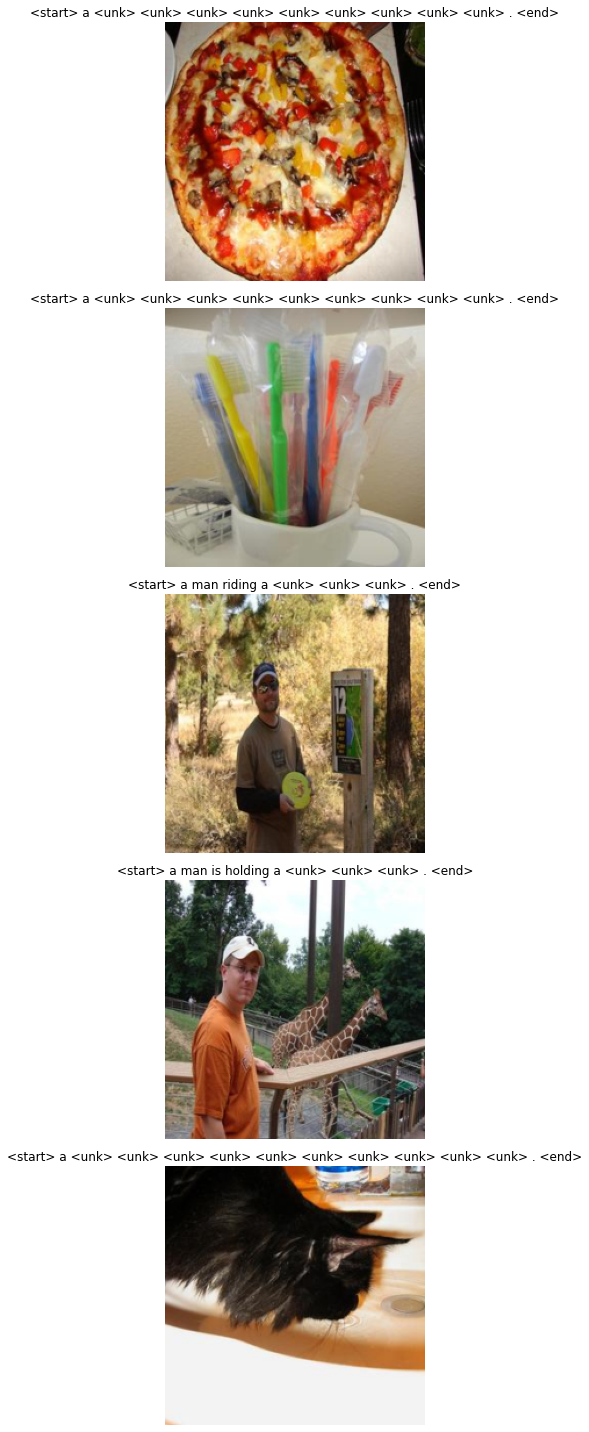

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
encoder.eval()
decoder.eval()

# 테스트 데이터셋에서 무작위로 5개의 샘플 선택
test_samples = random.sample(range(len(test_data_loader.dataset)), 5)

# 결과를 저장할 리스트
results = []

with torch.no_grad():
    for idx in test_samples:
        # 샘플 불러오기
        image, _ = test_data_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)
        
        # 모델을 통해 예측 수행
        features = encoder(image)
        sampled_ids = decoder.sample(features)
        sampled_ids = sampled_ids[0].cpu().numpy()

        # 예측된 단어 ID를 텍스트로 변환
        predicted_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            predicted_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(predicted_caption)

        # 결과 저장
        image = image.cpu().squeeze(0)
        results.append((image, sentence))

# 결과 시각화
fig, axes = plt.subplots(len(results), 1, figsize=(10, 20))

for i, (image, sentence) in enumerate(results):
    ax = axes[i]
    img = transforms.ToPILImage()(image)
    ax.imshow(img)
    ax.set_title(sentence)
    ax.axis('off')

plt.tight_layout()
plt.show()
